# 01 - Análise dos Dados de Treino

A primeira etapa a ser feito durante o projeto é a __Análise dos Dados__. Como nesta avaliação, os dados de treino e teste já estão separados, iremos considerar que o teste é os dados com o modelo já em produção. __Sendo assim, apenas o melhor modelo treinado será utilizado no conjunto de teste, para não ter nenhum vazamento de informação.__

## Pacotes e inicializações importantes

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

%matplotlib inline
sns.set()

# usado para o valor float do Pandas ficar neste formato
pd.options.display.float_format = '{:,.2f}'.format

# Tamanho da Figura ao imprimir os gráficos
rcParams['figure.figsize'] = 15, 10

## Leitura dos dados de treino

In [159]:
train_path = '../data/raw/treino.csv'

df = pd.read_csv(train_path, sep=',')
df.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


# Análise Inicial

Antes de fazer uma análise a fundo das variáveis, será feito uma análise inicial que dará as seguintes informações:

* Formato do `DataFrame` (Quantidade de Linhas, Quantidade de Colunas)
* Distribuição da variável **inadimplente** (estamos trabalhando com um conjunto de dados balanceado?)
* Os tipos de cada uma das variáveis

Antes de tudo, podemos verificar o tamanho do `DataFrame` para se ter uma noção da quantidade de dados que serão utilizados

In [15]:
df.shape

(110000, 11)

Outro ponto importante que é bom avaliar prematuramente é a distribuição dos dados, para verificar se o dataset é balanceado ou não.

In [47]:
# organiza os dados em formato de DataFrame
info = pd.DataFrame(df['inadimplente'].value_counts())
info.columns = ['quantidade']
info['porcentagem'] = info['quantidade'] / info['quantidade'].sum()
info.index = ['Não Inadimplente', 'Inadimplente']

info

,quantidade,porcentagem
Não Inadimplente,102669,0.93
Inadimplente,7331,0.07


Além da visualização em formato `DataFrame`, é possível apresentar a informação em um gráfico de pizza, para termos uma noção de proporção dos dados.

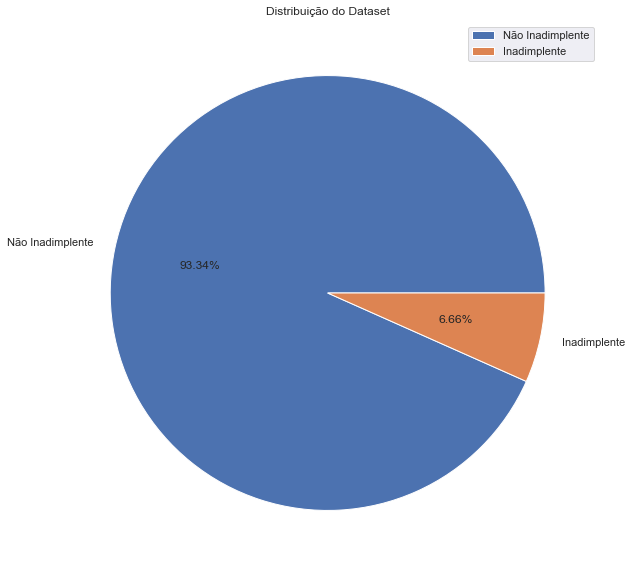

In [51]:
info.plot.pie(y='quantidade', autopct="%.2f%%")

plt.title('Distribuição do Dataset')
plt.ylabel('')
plt.show()

Neste caso, a distribuição da variável **inadimplente** é de 93/7, onde 93% dos dados **NÃO SÃO** inadimplentes e 7% **SÃO** inadimplentes. Isto é algo para se tomar cuidado, pois em um modelo que apenas respondesse como **NÃO INADIMPLENTE** teria uma acurácia de 93%, o que parece bom como um resultado sem nenhum contexto, mas se tratando de um modelo que não é capaz de fazer nada. 

E por fim, verificamos os tipos de cada uma das variáveis do `DataFrame` através do método **dtypes**

In [16]:
df.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

Todas as variáveis do dataset são númericas, o que já é um trabalho a menos pois não teremos que trabalhar com transformações necessárias em variáveis categóricas.

Com as informações adquiridas, podemos passar para uma análise mais afundo de cada uma das variáveis.

# Análisando cada uma das variáveis

Nesta seção será feito uma análise mais afundo de cada uma das variáveis, onde será verificado sua distribuição, se existe valores *outliers* e se seu comportamento é muito diferente no caso de ser **inadimplente ou não**.

No arquivo **README.md** do projeto é feito uma descrição de cada uma das variáveis. Esta informação será apresentada aqui para ter um melhor entendimento de cada uma delas (removendo a variável **inadimplente**)

| Váriavel 	| Descrição 	|
|:-	|:-	|
| idade | *A idade do cliente* |
| numero_de_dependentes | *O número de pessoas dependentes do cliente* |
| salario_mensal | *Salário mensal do cliente* |
| numero_emprestimos_imobiliarios | *Quantidade de empréstimos imobiliários que o cliente possui em aberto* |
| numero_vezes_passou_90_dias | *Número de vezes que o tomador passou mais de 90 dias em atraso* |
| util_linhas_inseguras | *Quanto que o cliente está usando, relativamente ao limite dele, de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc* |
| vezes_passou_de_30_59_dias | *Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo* |
| razao_debito | *Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio* |
| numero_linhas_crdto_aberto | *Número de empréstimos em aberto pelo cliente* |
| numero_de_vezes_que_passou_60_89_dias | *Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo* |

**Para uma melhor organização, a análise será feita na mesma ordem da tabela.**

## Variável: `idade`

A variável idade é auto explicatória, pois indica a idade do cliente.

### Valores `NaNs`

Uma das primeiras verificações a ser feita ao avaliar uma coluna é procurar a presença de valores **NaNs** (ou nulos)

In [167]:
def verifica_nans(column):
    total = df[column].isna().sum()
    true_qt = df.query('inadimplente == 1')[column].isna().sum()
    false_qt = total - true_qt
    
    print('Verificando a coluna', column)
    print('Quantidade de valores nulos:', total)
    print('Quantidade de valores nulos (inadimplente):', true_qt)
    print('Quantidade de valores nulos (não inadimplente):', false_qt)

In [168]:
verifica_nans('idade')

Verificando a coluna idade
Quantidade de valores nulos: 0
Quantidade de valores nulos (inadimplente): 0
Quantidade de valores nulos (não inadimplente): 0


No caso da variável **idade**, não existe nenhum registro de valores nulos.

### Distribuição

A primeira etapa de verificar a variável, é apresentar sua distribuição. Felizmente, o **Pandas** possuí um método `describe` que já ajuda bastante neste processo, pois apresenta informações sobre a média, desvio padrão, valor mínimo, primeiro quartil, mediana, terceiro quartil e valor máximo.

In [18]:
df['idade'].describe()

count   110,000.00
mean         52.26
std          14.77
min           0.00
25%          41.00
50%          52.00
75%          63.00
max         109.00
Name: idade, dtype: float64

Além disso, utilizando o método `groupby` do **Pandas**, é possível agrupar os dados pelos valores de uma variável. Neste caso, utilizando a coluna **inadimplente**, é possível visualizar a distribuição da idade para os dados de inadimplentes e não inadimplentes.

In [57]:
df.groupby('inadimplente')['idade'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",52.71,14.78,0.00,42.00,52.00,63.00,109.00
1,"7,331.00",45.94,13.00,21.00,36.00,45.00,54.00,99.00


Em conjunto com a visualização das distribuições, podemos verificar os dados através do seu histograma. Onde cada valor encontrado é quantificado para visualizar como é sua distribuição. Como os dados são bastante desbalanceados, será verificado a porcentagem de cada valor ao conjunto total ao inves da sua quantidade exata.

**neste exemplo, será usado 110 bins, pois teremos um "bin" (classe) para cada uma das idades (0 até 109, com o 0 incluído)**

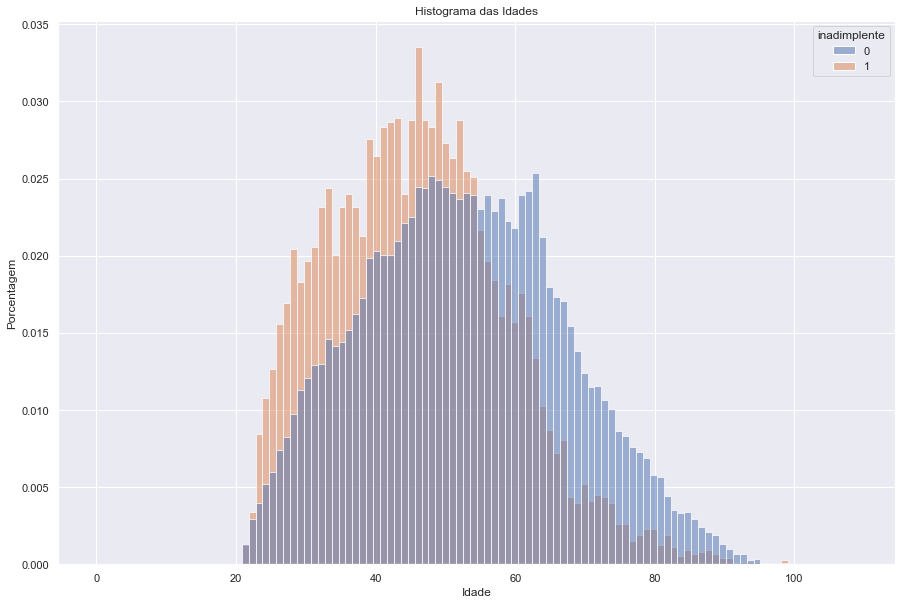

In [85]:
sns.histplot(data=df, x='idade', hue='inadimplente', bins=110, 
             stat='probability', common_norm=False)

plt.title('Histograma das Idades')
plt.xlabel('Idade')
plt.ylabel('Porcentagem')
plt.show()

Através da observação do gráfico, é possível verificar que a distribuição da idade nos **inadimplentes** está mais a esquerda, significando que em idades menores, a possibilidade de ser **inadimplente** é maior. Mesmo assim, essa diferença não é tão grande, em um modelo de *Machine Learning*, está informação pode ser utilizada mas não parece ser a melhor indicação.

### *Outliers*

Um dado é chamado de **outlier** quando ele possuí um valor muito diferente da distribuição em si. Como a frase "muito diferente" pode indicar muitas coisas, existe algumas técnicas para encontrar tais valores. As mais utilizadas são as seguintes:

* *Z-Score* - Verifica a distância do valor pra média, utilizando o desvio padrão. Em outras palavras, quantos "desvio padrão" o valor está da média. Em técnicas para eliminar outliers, normalmente é retirado valores que possuem um *Z-Score* maior que 3.
* Distância Interquartilica - Neste método, é utilizado a distância interquartilica (IQR) para eliminar valores *outliers* do conjunto de dados. A IQR é calculado através do intervalo entre o Q3 e Q1. Para ver se um valor é outlier, é utilizado a fórmula: $Q1 - 1.5 * IQR$ para valores menores que o Q1 e $Q3 + 1.5 * IQR$ para valores maiores que o Q3.

O Método da distância interquartilica é utilizado para verificar *outliers* em um gráfico de caixa. No nosso caso iremos utilizar o *Z-Score* para eliminar os outliers mas faremos a visualização através do gráfico de caixa.

In [155]:
outliers = df[(np.abs(stats.zscore(df['idade'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 36


E agora podemos visualizar os dados representados por um gráfico de caixa.

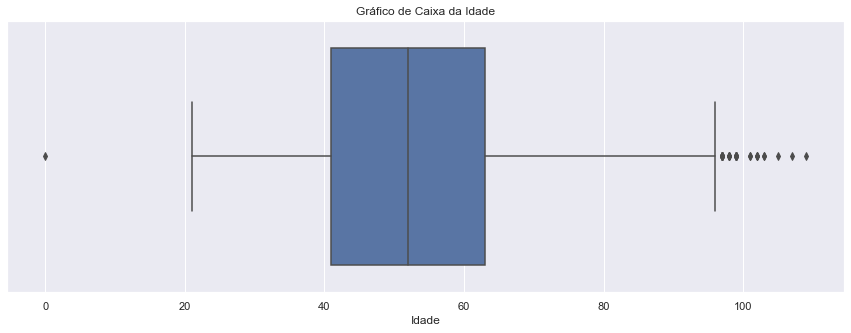

In [122]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='idade')

plt.title('Gráfico de Caixa da Idade')
plt.xlabel('Idade')
plt.show()

Os pontos fora dos limites dos "bigodes" do gráfico são os valores outliers. Podemos pegar a quantidade exata através da formula matemática.

In [127]:
def outliers_iqr(column):
    q1 = df[column].quantile(.25)
    q3 = df[column].quantile(.75)
    iqr = q3 - q1

    down_limit = q1 - 1.5 * iqr
    up_limit = q3 + 1.5 * iqr
    
    outliers = df[(df[column] > up_limit) | (df[column] < down_limit)]
    print('Quantidade de Outliers (IQR):', outliers.shape[0])

In [128]:
outliers_iqr('idade')

Quantidade de Outliers (IQR): 36


## Variável: `numero_de_dependentes`

Esta variável indica a quantidade de depentes que o cliente possuí.

### Valores `NaNs`

In [169]:
verifica_nans('numero_de_dependentes')

Verificando a coluna numero_de_dependentes
Quantidade de valores nulos: 2878
Quantidade de valores nulos (inadimplente): 132
Quantidade de valores nulos (não inadimplente): 2746


In [170]:
df['numero_de_dependentes'].describe()

count   107,122.00
mean          0.76
std           1.11
min           0.00
25%           0.00
50%           0.00
75%           1.00
max          20.00
Name: numero_de_dependentes, dtype: float64

In [171]:
df.groupby('inadimplente')['numero_de_dependentes'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"99,923.00",0.74,1.11,0.00,0.00,0.00,1.00,20.00
1,"7,199.00",0.94,1.21,0.00,0.00,0.00,2.00,8.00


In [172]:
df['numero_de_dependentes'] = df['numero_de_dependentes'].fillna(0)

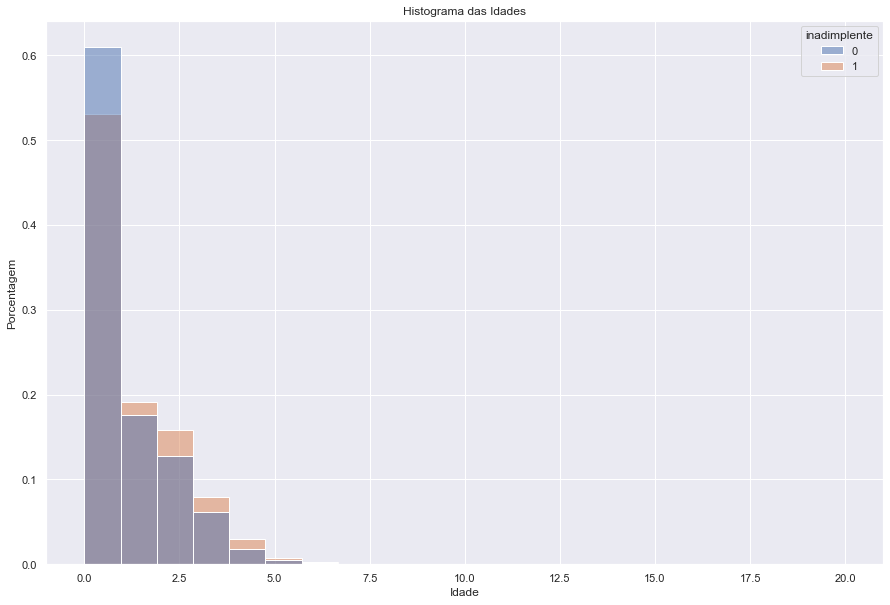

In [173]:
sns.histplot(data=df, x='numero_de_dependentes', hue='inadimplente', bins=21,
             stat='probability', common_norm=False)

plt.title('Histograma das Idades')
plt.xlabel('Idade')
plt.ylabel('Porcentagem')
plt.show()

In [174]:
outliers = df[(np.abs(stats.zscore(df['numero_de_dependentes'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 739


In [175]:
outliers_iqr('numero_de_dependentes')

Quantidade de Outliers (IQR): 9748


## Variável: `salario_mensal`

In [176]:
verifica_nans('salario_mensal')

Verificando a coluna salario_mensal
Quantidade de valores nulos: 21763
Quantidade de valores nulos (inadimplente): 1247
Quantidade de valores nulos (não inadimplente): 20516


In [177]:
df['salario_mensal'].describe()

count      88,237.00
mean        6,637.41
std        13,383.95
min             0.00
25%         3,400.00
50%         5,400.00
75%         8,225.00
max     3,008,750.00
Name: salario_mensal, dtype: float64

In [178]:
df.groupby('inadimplente')['salario_mensal'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"82,153.00","6,711.24","13,755.72",0.00,"3,465.00","5,455.00","8,333.00","3,008,750.00"
1,"6,084.00","5,640.44","6,467.50",0.00,"3,000.00","4,500.00","6,800.00","250,000.00"


In [182]:
x = df.query('inadimplente == 1')
y = df.query('inadimplente == 0')

print(x[x['salario_mensal'] == 0].shape[0])
print(y[y['salario_mensal'] == 0].shape[0])

47
1169


In [180]:
df.groupby('inadimplente')['salario_mensal'].count()

inadimplente
0    82153
1     6084
Name: salario_mensal, dtype: int64

## Variável: `numero_emprestimos_imobiliarios`

In [183]:
verifica_nans('numero_emprestimos_imobiliarios')

Verificando a coluna numero_emprestimos_imobiliarios
Quantidade de valores nulos: 0
Quantidade de valores nulos (inadimplente): 0
Quantidade de valores nulos (não inadimplente): 0


In [184]:
df['numero_emprestimos_imobiliarios'].describe()

count   110,000.00
mean          1.02
std           1.14
min           0.00
25%           0.00
50%           1.00
75%           2.00
max          54.00
Name: numero_emprestimos_imobiliarios, dtype: float64

In [185]:
df.groupby('inadimplente')['numero_emprestimos_imobiliarios'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",1.02,1.11,0.00,0.00,1.00,2.00,54.00
1,"7,331.00",0.99,1.47,0.00,0.00,1.00,2.00,29.00


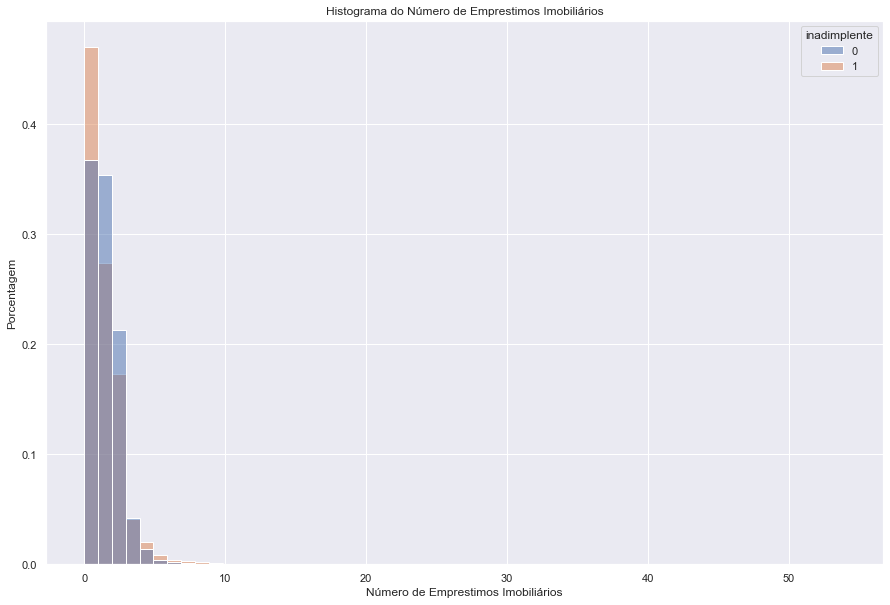

In [189]:
sns.histplot(data=df, x='numero_emprestimos_imobiliarios', hue='inadimplente', bins=55, 
             stat='probability', common_norm=False)

plt.title('Histograma do Número de Emprestimos Imobiliários')
plt.xlabel('Número de Emprestimos Imobiliários')
plt.ylabel('Porcentagem')
plt.show()

In [190]:
outliers = df[(np.abs(stats.zscore(df['numero_emprestimos_imobiliarios'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 1081


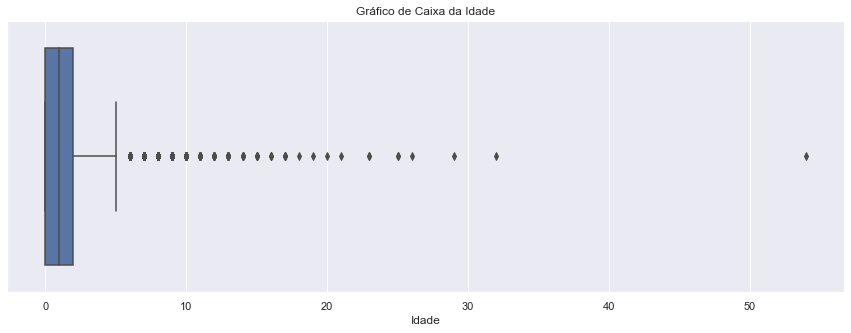

In [191]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='numero_emprestimos_imobiliarios')

plt.title('Gráfico de Caixa da Idade')
plt.xlabel('Idade')
plt.show()

In [192]:
outliers_iqr('numero_emprestimos_imobiliarios')

Quantidade de Outliers (IQR): 585


In [196]:
df = df.fillna(0)

In [199]:
outliers = df[~(np.abs(stats.zscore(df)) < 3).all(axis=1)]
outliers

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
4,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00
13,1,0.96,40,3,0.38,"13,700.00",9,3,1,1,2.00
21,1,0.03,38,0,0.48,"3,000.00",7,0,1,0,2.00
25,1,0.39,50,0,1.60,"4,676.00",14,0,3,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
109946,0,0.09,78,0,0.48,"11,220.00",7,0,5,0,1.00
109947,0,0.43,76,0,"6,357.00",0.00,24,0,4,0,0.00
109965,0,0.66,57,0,0.36,"5,500.00",28,0,1,0,0.00
109976,0,0.93,38,0,0.17,"3,118.00",5,0,0,0,6.00


In [200]:
outliers['inadimplente'].value_counts()

1    7331
0    3515
Name: inadimplente, dtype: int64

In [ ]:
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [ ]:
"""
numero_emprestimos_imobiliarios 
numero_vezes_passou_90_dias 
util_linhas_inseguras 
vezes_passou_de_30_59_dias 
razao_debito 
numero_linhas_crdto_aberto 
numero_de_vezes_que_passou_60_89_dias 
"""